<a href="https://colab.research.google.com/github/cseazeem/hourly-energy-forecast/blob/master/hourly_energy_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 IMPORTS

In [1]:
!git clone https://github.com/cseazeem/hourly-energy-forecast.git


Cloning into 'hourly-energy-forecast'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 29 (delta 1), reused 25 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 11.93 MiB | 7.75 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
!pip install boruta xgboost holidays tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

from IPython.core.display  import HTML
from IPython.display       import Image
from datetime              import date
from tabulate              import tabulate
from scipy.stats           import chi2_contingency

from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
import xgboost as xgb

import random
import warnings
warnings.filterwarnings( 'ignore' )

## 0.1 Helper Function

In [4]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def cross_validation( X_training, kfold, model_name, model, verbose=False ):

    mae_list  = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date_1  = X_training[X_training['electric_company']==1]['datetime'].max() - datetime.timedelta( days=k*12*30 )
        validation_start_date_2  = X_training[X_training['electric_company']==2]['datetime'].max() - datetime.timedelta( days=k*12*30 )
        validation_start_date_3  = X_training[X_training['electric_company']==3]['datetime'].max() - datetime.timedelta( days=k*12*30 )
        validation_start_date_4  = X_training[X_training['electric_company']==4]['datetime'].max() - datetime.timedelta( days=k*12*30 )
        validation_start_date_5  = X_training[X_training['electric_company']==5]['datetime'].max() - datetime.timedelta( days=k*12*30 )
        validation_start_date_6  = X_training[X_training['electric_company']==6]['datetime'].max() - datetime.timedelta( days=k*12*30 )
        validation_start_date_7  = X_training[X_training['electric_company']==7]['datetime'].max() - datetime.timedelta( days=k*12*30 )
        validation_start_date_8  = X_training[X_training['electric_company']==8]['datetime'].max() - datetime.timedelta( days=k*12*30 )
        validation_start_date_9  = X_training[X_training['electric_company']==9]['datetime'].max() - datetime.timedelta( days=k*12*30 )
        validation_start_date_10 = X_training[X_training['electric_company']==10]['datetime'].max() - datetime.timedelta( days=k*12*30 )
        validation_start_date_11 = X_training[X_training['electric_company']==11]['datetime'].max() - datetime.timedelta( days=k*12*30 )
        validation_start_date_12 = X_training[X_training['electric_company']==12]['datetime'].max() - datetime.timedelta( days=k*12*30 )

        validation_end_date_1    = X_training[X_training['electric_company']==1]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )
        validation_end_date_2    = X_training[X_training['electric_company']==2]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )
        validation_end_date_3    = X_training[X_training['electric_company']==3]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )
        validation_end_date_4    = X_training[X_training['electric_company']==4]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )
        validation_end_date_5    = X_training[X_training['electric_company']==5]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )
        validation_end_date_6    = X_training[X_training['electric_company']==6]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )
        validation_end_date_7    = X_training[X_training['electric_company']==7]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )
        validation_end_date_8    = X_training[X_training['electric_company']==8]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )
        validation_end_date_9    = X_training[X_training['electric_company']==9]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )
        validation_end_date_10   = X_training[X_training['electric_company']==10]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )
        validation_end_date_11   = X_training[X_training['electric_company']==11]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )
        validation_end_date_12   = X_training[X_training['electric_company']==12]['datetime'].max() - datetime.timedelta( days=(k-1)*12*30 )

        # filtering dataset
        training = X_training[ ( (X_training['electric_company']==1) & (X_training['datetime'] < validation_start_date_1) )
                 | ( (X_training['electric_company']==2) & (X_training['datetime'] < validation_start_date_2) )
                 | ( (X_training['electric_company']==3) & (X_training['datetime'] < validation_start_date_3) )
                 | ( (X_training['electric_company']==4) & (X_training['datetime'] < validation_start_date_4) )
                 | ( (X_training['electric_company']==5) & (X_training['datetime'] < validation_start_date_5) )
                 | ( (X_training['electric_company']==6) & (X_training['datetime'] < validation_start_date_6) )
                 | ( (X_training['electric_company']==7) & (X_training['datetime'] < validation_start_date_7) )
                 | ( (X_training['electric_company']==8) & (X_training['datetime'] < validation_start_date_8) )
                 | ( (X_training['electric_company']==9) & (X_training['datetime'] < validation_start_date_9) )
                 | ( (X_training['electric_company']==10)  & (X_training['datetime'] < validation_start_date_10) )
                 | ( (X_training['electric_company']==11) & (X_training['datetime'] < validation_start_date_11) )
                 | ( (X_training['electric_company']==12) & (X_training['datetime'] < validation_start_date_12) ) ]

        validation = X_training[ ( (X_training['electric_company']==1) & (X_training['datetime'] >= validation_start_date_1) & (X_training['datetime'] <= validation_end_date_1) )
                 | ( (X_training['electric_company']==2) & (X_training['datetime'] >= validation_start_date_2) & (X_training['datetime'] <= validation_end_date_2) )
                 | ( (X_training['electric_company']==3) & (X_training['datetime'] >= validation_start_date_3) & (X_training['datetime'] <= validation_end_date_3) )
                 | ( (X_training['electric_company']==4) & (X_training['datetime'] >= validation_start_date_4) & (X_training['datetime'] <= validation_end_date_4) )
                 | ( (X_training['electric_company']==5) & (X_training['datetime'] >= validation_start_date_5) & (X_training['datetime'] <= validation_end_date_5) )
                 | ( (X_training['electric_company']==6) & (X_training['datetime'] >= validation_start_date_6) & (X_training['datetime'] <= validation_end_date_6) )
                 | ( (X_training['electric_company']==7) & (X_training['datetime'] >= validation_start_date_7) & (X_training['datetime'] <= validation_end_date_7) )
                 | ( (X_training['electric_company']==8) & (X_training['datetime'] >= validation_start_date_8) & (X_training['datetime'] <= validation_end_date_8) )
                 | ( (X_training['electric_company']==9) & (X_training['datetime'] >= validation_start_date_9) & (X_training['datetime'] <= validation_end_date_9) )
                 | ( (X_training['electric_company']==10) & (X_training['datetime'] >= validation_start_date_10) & (X_training['datetime'] <= validation_end_date_10) )
                 | ( (X_training['electric_company']==11) & (X_training['datetime'] >= validation_start_date_11) & (X_training['datetime'] <= validation_end_date_11) )
                 | ( (X_training['electric_company']==12) & (X_training['datetime'] >= validation_start_date_12) & (X_training['datetime'] <= validation_end_date_12) ) ]

        # training and validation dataset
        # training
        xtraining = training.drop( ['datetime', 'mw_energy_consumption' ], axis=1 )
        ytraining = training['mw_energy_consumption']

        #validation
        xvalidation = validation.drop( ['datetime', 'mw_energy_consumption'], axis=1 )
        yvalidation = validation['mw_energy_consumption']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold interation
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( (y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [6]:
%cd hourly-energy-forecast


/content/hourly-energy-forecast


In [7]:
!ls data


AEP_hourly.csv	   DOM_hourly.csv   NI_hourly.csv	 PJMW_hourly.csv
COMED_hourly.csv   DUQ_hourly.csv   PJME_hourly.csv
DAYTON_hourly.csv  EKPC_hourly.csv  pjm_hourly_est.csv
DEOK_hourly.csv    FE_hourly.csv    PJM_Load_hourly.csv


In [8]:
aep = pd.read_csv( 'data/AEP_hourly.csv', low_memory=False )
comed = pd.read_csv( 'data/COMED_hourly.csv', low_memory=False )
dayton = pd.read_csv( 'data/DAYTON_hourly.csv', low_memory=False )
deok = pd.read_csv( 'data/DEOK_hourly.csv', low_memory=False )
dom = pd.read_csv( 'data/DOM_hourly.csv', low_memory=False )
duq = pd.read_csv( 'data/DUQ_hourly.csv', low_memory=False )
ekpc = pd.read_csv( 'data/EKPC_hourly.csv', low_memory=False )
fe = pd.read_csv( 'data/FE_hourly.csv', low_memory=False )
ni = pd.read_csv( 'data/NI_hourly.csv', low_memory=False )
pjm = pd.read_csv( 'data/PJM_Load_hourly.csv', low_memory=False )
pjme = pd.read_csv( 'data/PJME_hourly.csv', low_memory=False )
pjmw = pd.read_csv( 'data/PJMW_hourly.csv', low_memory=False )

In [9]:
# I will combine all the datasets into one. For this I will create a column in each of the datasets that will identify your respective electric company.

aep['electric_company'] = 'AEP'
comed['electric_company'] = 'COMED'
dayton['electric_company'] = 'DAYTON'
deok['electric_company'] = 'DEOK'
dom['electric_company'] = 'DOM'
duq['electric_company'] = 'DUQ'
ekpc['electric_company'] = 'EKPC'
fe['electric_company'] = 'FE'
ni['electric_company'] = 'NI'
pjm['electric_company'] = 'PJM'
pjme['electric_company'] = 'PJME'
pjmw['electric_company'] = 'PJMW'

In [10]:
# the column in each dataset that shows the Megawatt Energy Consumption, I will rename it with the same name in all.

aep = aep.rename( columns={'AEP_MW': 'mw_energy_consumption'} )
comed = comed.rename( columns={'COMED_MW': 'mw_energy_consumption'} )
dayton = dayton.rename( columns={'DAYTON_MW': 'mw_energy_consumption'} )
deok = deok.rename( columns={'DEOK_MW': 'mw_energy_consumption'} )
dom = dom.rename( columns={'DOM_MW': 'mw_energy_consumption'} )
duq = duq.rename( columns={'DUQ_MW': 'mw_energy_consumption'} )
ekpc = ekpc.rename( columns={'EKPC_MW': 'mw_energy_consumption'} )
fe = fe.rename( columns={'FE_MW': 'mw_energy_consumption'} )
ni = ni.rename( columns={'NI_MW': 'mw_energy_consumption'} )
pjm = pjm.rename( columns={'PJM_Load_MW': 'mw_energy_consumption'} )
pjme = pjme.rename( columns={'PJME_MW': 'mw_energy_consumption'} )
pjmw = pjmw.rename( columns={'PJMW_MW': 'mw_energy_consumption'} )

In [11]:
# Concatenate all the datasets
df_raw = pd.concat( [aep, comed, dayton, deok, dom, duq, ekpc, fe, ni, pjm, pjme, pjmw] )
df_raw.sample(5) # check

,Datetime,mw_energy_consumption,electric_company
72029,2013-10-14 00:00:00,1389.0,DUQ
96740,2016-12-17 16:00:00,1664.0,DUQ
129137,2016-01-08 19:00:00,6491.0,PJMW
123906,2016-11-11 20:00:00,30153.0,PJME
44637,2009-07-30 08:00:00,10585.0,NI


In [12]:
df_raw.shape

(1090167, 3)

# 1.0 STEP 01 - DESCRIPTION OF DATA

In [13]:
# At the beginning of each step I will make a copy of the dataset to make it easier to reload the data in case there is a problem with the project.
df1 = df_raw.copy()

## 1.1 Rename Columns

In [14]:
# Although I already renamed some columns when I was preparing the datasets to concatenate them, I will check if there are any more columns that are not in the format I want them to be.
df1.columns

Index(['Datetime', 'mw_energy_consumption', 'electric_company'], dtype='object')

In [15]:
# Only the column "Datetime" don't have the format that I want.
cols_old = ['Datetime', 'mw_energy_consumption', 'electric_company']

# If the dataset had too many columns to change I would use the "snakecase" technique through the "inflection" function. Since this dataset has only one column to change the name, I will do this process manually.
cols_new = ['datetime', 'mw_energy_consumption', 'electric_company']

# rename
df1.columns = cols_new

In [16]:
df1.columns

Index(['datetime', 'mw_energy_consumption', 'electric_company'], dtype='object')

## 1.2 Data Dimensions

In [17]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 1090167
Number of Cols: 3


## 1.3 Data Types

In [18]:
df1.dtypes
# Observe datetime. It has a different data type.

,0
datetime,object
mw_energy_consumption,float64
electric_company,object


In [19]:
# function "datetime" transforma the columns "datetime" from object (string) to datetime.
df1['datetime'] = pd.to_datetime( df1['datetime'] )

In [20]:
df1.dtypes

,0
datetime,datetime64[ns]
mw_energy_consumption,float64
electric_company,object


## 1.4 Check NA

In [21]:
df1.isna().sum()

,0
datetime,0
mw_energy_consumption,0
electric_company,0


## 1.5 Fillout NA

In [22]:
# We don't have NA value to fillout... :)

## 1.6 Change Types

In [23]:
# We already did the change types.

## 1.7 Descriptive Statistical

In [24]:
# divide into numerical and categorical columns, as they will be treated with different techniques.
num_attributes = df1.select_dtypes( include=['float64'] )
cat_attributes = df1.select_dtypes( exclude=['float64', 'datetime64[ns]'] )

In [25]:
num_attributes.sample()

,mw_energy_consumption
13422,16460.0


In [26]:
cat_attributes.sample()

,electric_company
6001,EKPC


### 1.7.1 Numerical Attibutes

In [27]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [28]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,mw_energy_consumption,0.0,62009.0,62009.0,11209.58865,8217.0,10534.394704,1.356423,1.198281


<Axes: xlabel='mw_energy_consumption', ylabel='Density'>

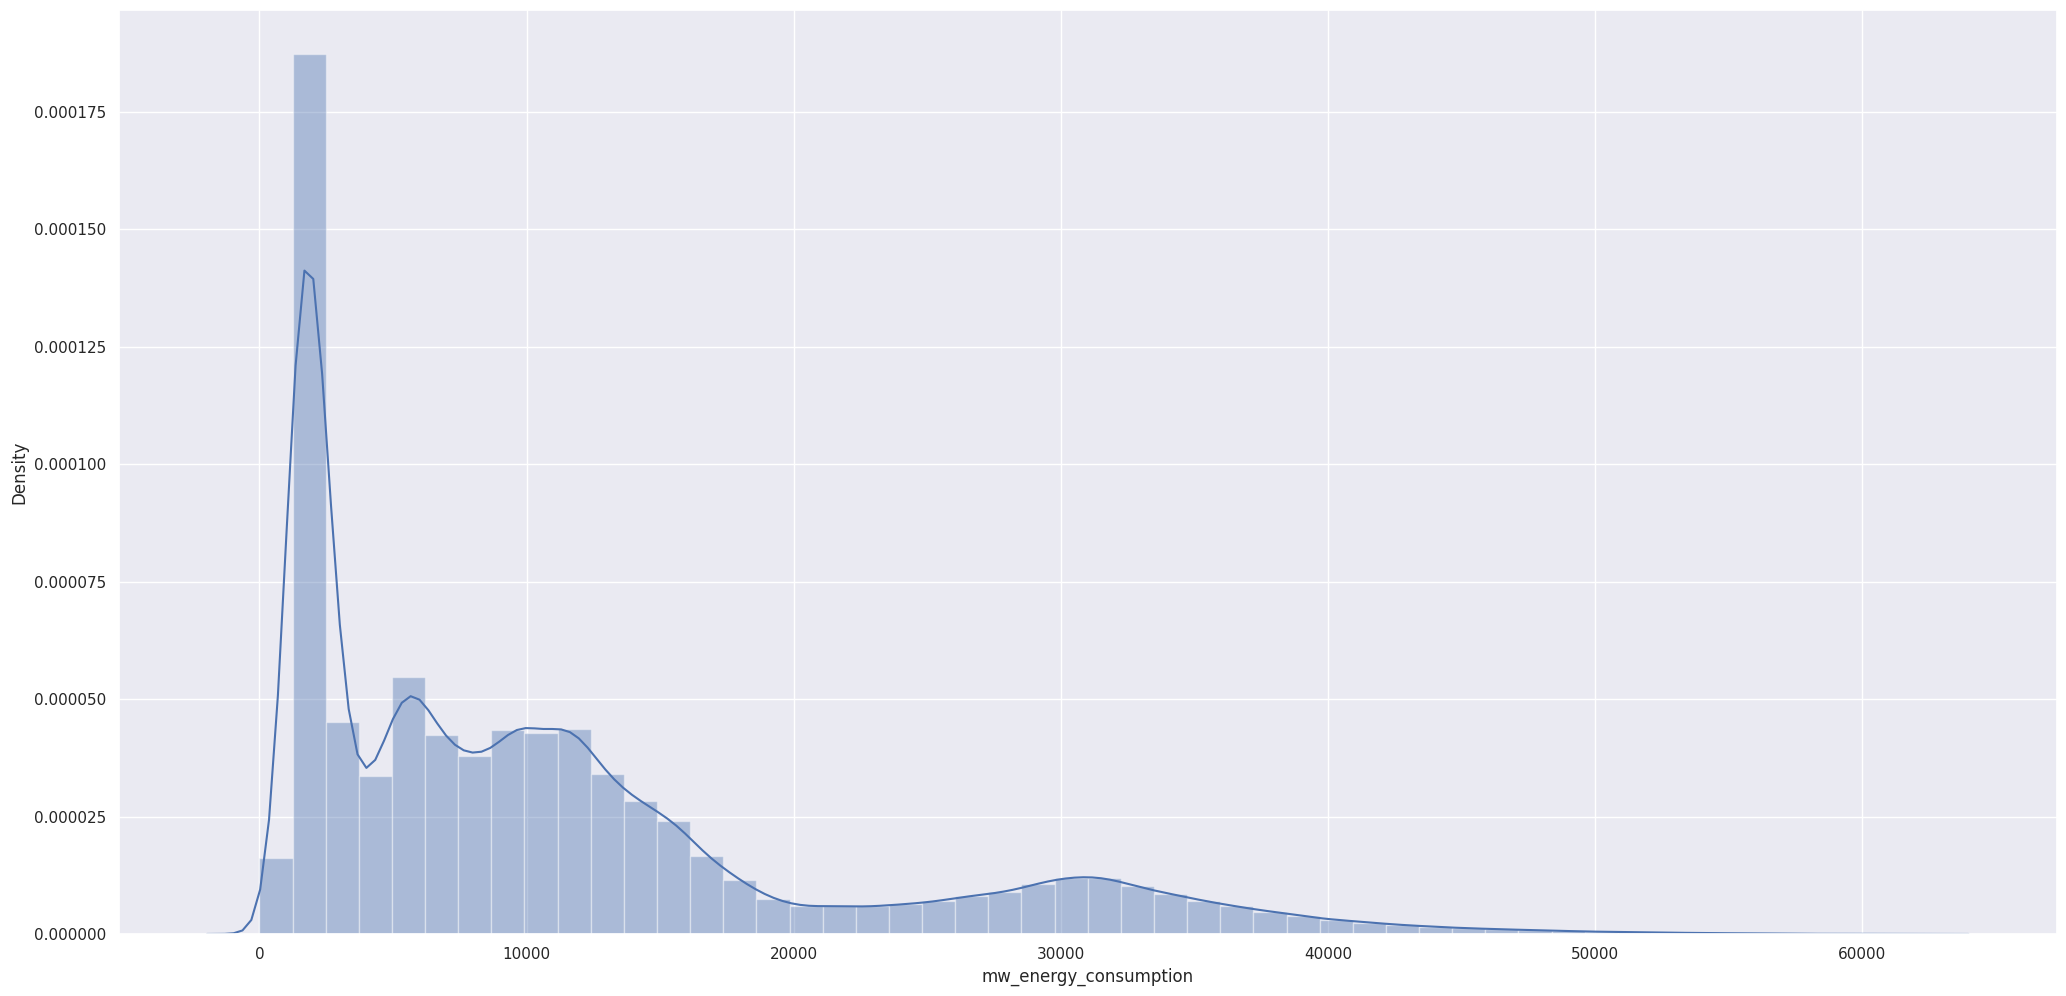

In [29]:
sns.distplot( df1['mw_energy_consumption'] )

### 1.7.2 Categorical Attibutes

In [30]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

,0
electric_company,12


In [ ]:
sns.boxplot( x= 'electric_company', y='mw_energy_consumption' , data=df1 )

# 2.0 STEP 02 - FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()

In [ ]:
Image( 'image/Hyphoteses_Map.png' )
# As we can see in the Hypothesis Map below, there are many factors that influence the consumption of electricity and that we could use to try to predict them.
# The point is that we only have "datetime" information in the dataset. Because of this we will only use a few elements and their attributes.

## 2.1 Creation of Hypotheses

### 2.1.1 Demographic Hypotheses

**1.** Older people spend less energy

**2.** Larger families spend more energy

**3.** Female people spend more energy

**4.** Family activity influences energy expenditure in the early morning and late afternoon.

### 2.1.2 Geographic Hypotheses

**1.** Seasons with higher temperatures use more energy

**2.** Locations present in geographic accidents spend more energy

**3.** Climate with higher temperatures use more energy

### 2.1.3 Sociocultural Hypotheses

**1.** Routines that start when there is less sunlight use more energy

**2.** Tribes spend less energy

**3.** Nations spend more energy

**4.** Communities spend less energy

**5.** Holiday periods spend more energy

## 2.2 Final List of Hypotheses

**1.** Family activity influences energy expenditure in the early morning and late afternoon only

**2.** Seasons with higher or lower temperatures use more energy

**3.** Holiday periods spend more energy

**4.** Weekends periods spend more energy

## 2.3 Feature Engineering

In [ ]:
## date
# I want to have a view of the evolution of energy consumption by looking only at the dates as information, excluding an hour when they were recorded.

df2['date'] = df2['datetime'].dt.date

## year
# I will not directly validate any hypothesis with the date "year", but I will use this information to better visualize some variables in the validation process within the EDA.

df2['year'] = df2['datetime'].dt.year

## month
# I will not directly validate any hypothesis with the date "month", but I will use this information to better visualize some variables in the validation process within the EDA.

df2['month'] = df2['datetime'].dt.month

## hour_of_day:

# Initially I thought about converting the hours in the "datetime" column to float, because it would be better to visualize the energy consumption by the evolution of the hours, but observing the part of the hours in the "datetime" column we can see that all of them have only the same hour and not the minute and second. For this reason I will only create the "hour_of_day" column using the "hour" function.

df2['hour_of_day'] = df2['datetime'].dt.hour

# season:

# - Winter -> December (12), January (01) and February (02);
# - Spring -> March (03), April (04) and May (05);
# - Summer -> Jun (06), July (07) and August (08);
# - Autumn -> September (09), October (10) and November (11).

df2['season'] = df2['datetime'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or x.month == 2 else 'Spring' if  x.month == 3 or x.month == 4 or x.month == 5 else 'Summer' if  x.month == 6 or x.month == 7 or x.month == 8 else 'Autumn' if  x.month == 9 or x.month == 10 or x.month == 11 else '')

## holiday:

# I will use the "holidays" library to identify whether the date represents a holiday. An idea for a next cycle in the project is to differentiate, according to some rule, the different dates of the holidays.
# The documentation of this librarie is in this link: https://pypi.org/project/holidays/
# Another rule that I will use is to consider the eve of the dates as a "holiday".

df2['holidays'] = df2['datetime'].apply( lambda x: 'Holiday' if x in holidays.US() else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US() else 'Normal day' )

## day_of_week:

# 0 - Monday
# 1 - Tuesday
# 2 - Wednesday
# 3 - Thursday
# 4 - Friday
# 5 - Saturday
# 6 - Sunday

df2['day_of_week'] = df2['datetime'].dt.weekday

In [ ]:
# Recheck data types after feature engineering
df2.dtypes

In [ ]:
# The column "date" is a datetime type columns, but it is like a object type column. I will change the type.
df2['date'] = pd.to_datetime( df2['date'] )

In [ ]:
df2.dtypes

In [ ]:
num_attributes = df2.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [ ]:
df2.sample(10).T

# 3.0 STEP 03 - VARIABLE FILTERING

In [ ]:
df3 = df2.copy()

In [ ]:
df3.head()

## 3.1 Line Filtering

In [ ]:
# There isn't any line filtering to do in this project

## 3.2 Column Selection

In [ ]:
# There isn't any column selection to do in this project

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [ ]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

In [ ]:
sns.distplot( df4['mw_energy_consumption'], kde=False )

### 4.1.2 Numerical Variable

In [ ]:
num_attributes.hist( bins=25 )

### 4.1.3 Categorical Variable

In [ ]:
cat_attributes.head()

In [ ]:
df4['electric_company'].drop_duplicates()

In [ ]:
df4['season'].drop_duplicates()

In [ ]:
df4['holidays'].drop_duplicates()

In [ ]:
# electric_company

plt.subplot( 3, 2, 1)
sns.countplot( df4['electric_company'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['electric_company'] == 'AEP']['mw_energy_consumption'], label='AEP', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'COMED']['mw_energy_consumption'], label='COMED', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'DAYTON']['mw_energy_consumption'], label='DAYTON', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'DEOK']['mw_energy_consumption'], label='DEOK', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'DOM']['mw_energy_consumption'], label='DOM', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'DUQ']['mw_energy_consumption'], label='DUQ', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'EKPC']['mw_energy_consumption'], label='EKPC', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'FE']['mw_energy_consumption'], label='FE', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'NI']['mw_energy_consumption'], label='NI', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'PJM']['mw_energy_consumption'], label='PJM', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'PJME']['mw_energy_consumption'], label='PJME', shade=True )
sns.kdeplot( df4[df4['electric_company'] == 'PJMW']['mw_energy_consumption'], label='PJMW', shade=True )

# season

plt.subplot( 3, 2, 3)
sns.countplot( df4['season'] )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['season'] == 'Winter']['mw_energy_consumption'], label='Winter', shade=True )
sns.kdeplot( df4[df4['season'] == 'Autumn']['mw_energy_consumption'], label='Autumn', shade=True )
sns.kdeplot( df4[df4['season'] == 'Summer']['mw_energy_consumption'], label='Summer', shade=True )
sns.kdeplot( df4[df4['season'] == 'Spring']['mw_energy_consumption'], label='Spring', shade=True )

# holidays

plt.subplot( 3, 2, 5)
sns.countplot( df4['holidays'] )

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['holidays'] == 'Holiday']['mw_energy_consumption'], label='Holiday', shade=True )
sns.kdeplot( df4[df4['holidays'] == 'Normal day']['mw_energy_consumption'], label='Normal day', shade=True )

## 4.2 Bivariate Analysis

### H1. Family activity influences energy expenditure in the early morning and late afternoon only

**FALSE** Energy consumption increases early in the morning, but it keeps increasing until it has another strong rise in the late afternoon and then falls.

In [ ]:
plt.subplot(1,3,1)
aux1 = df4[['hour_of_day', 'mw_energy_consumption']].groupby( 'hour_of_day' ).sum().reset_index()
sns.barplot( x='hour_of_day', y='mw_energy_consumption', data=aux1)

plt.subplot(1,3,2)
sns.regplot( x='hour_of_day', y='mw_energy_consumption', data=aux1 )

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H2. Seasons with higher or lower temperatures use more energy

**TRUE** When we see the sum of all energy consumptions, we see that winter and summer, which are the seasons with the most acute temperatures, register the highest energy consumption. At the same time when we spread out over the years we observe the same behavior with rare exceptions.

In [ ]:
aux1 = df4[['season', 'mw_energy_consumption']] \
        .groupby('season') \
        .sum() \
        .reset_index()

plt.subplot(2,1,1)
sns.barplot(
    x='season',
    y='mw_energy_consumption',
    data=aux1,
    order=['Winter', 'Spring', 'Summer', 'Autumn']
)

aux2 = df4[['year', 'season', 'mw_energy_consumption']] \
        .groupby(['year', 'season']) \
        .sum() \
        .reset_index()

plt.subplot(2,1,2)
sns.barplot(
    x='year',
    y='mw_energy_consumption',
    hue='season',
    data=aux2,
    hue_order=['Winter', 'Spring', 'Summer', 'Autumn']
)


### H3. Holiday periods spend more energy

**FALSE** Holiday periods spend less energy

In [ ]:
aux1 = df4[['holidays', 'mw_energy_consumption']].groupby( 'holidays' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='holidays', y='mw_energy_consumption', data=aux1 )

aux2 = df4[['year', 'holidays', 'mw_energy_consumption']].groupby( ['year', 'holidays'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='mw_energy_consumption', hue='holidays', data=aux2 );

### H4. Weekends periods spend more energy

**FALSE** Weekends periods spend less energy.

In [ ]:
plt.subplot( 2, 2, 1)
aux1 = df4[['day_of_week', 'mw_energy_consumption']].groupby( 'day_of_week' ).sum().reset_index()
sns.barplot( x='day_of_week', y='mw_energy_consumption', data=aux1)

aux2 = df4[['month', 'day_of_week', 'mw_energy_consumption']].groupby( ['month', 'day_of_week'] ).sum().reset_index()
plt.subplot( 2, 2, 2 )
sns.barplot( x='month', y='mw_energy_consumption', hue='day_of_week', data=aux2 );

plt.subplot(2, 2, 3)
sns.regplot( x='day_of_week', y='mw_energy_consumption', data=aux1 )

plt.subplot(2, 2, 4)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# To better understand what these numbers represent in relation to the days of the week follow the legend below:
# Integer Value             Day of the week
#      0                        Monday
#      1                       Tuesday
#      2                      Wednesday
#      3                      Thursday
#      4                       Friday
#      5                      Saturday
#      6                       Sunday

### 4.2.1 Summary of Hypotheses

In [ ]:
tab = [['Hypotheses', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'High'],
       ['H2', 'True', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'High']
      ]
print( tabulate( tab, headers='firstrow' ) )

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

In [ ]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

# As we can see, the numerical variables (year and month) that we created just to help visualize the evolution of energy consumption, have very little relevance.

### 4.3.2 Categorical Attributes

In [ ]:
# # When we are working with categorical variables we use another statistical technique to visualize the correlations between them. This technique is called "Cramér's V" and a function was created with its formula and it is in the section "0.1 Helper Function".
# # In practice, below I will create by hand the correlation table between categorical variables.

# # Only categorical data
# c1 = cramer_v( cat_attributes['electric_company'], cat_attributes['electric_company'] )

# # Calculate cramer V
# c2 = cramer_v( cat_attributes['electric_company'], cat_attributes['season'] )
# c3 = cramer_v( cat_attributes['electric_company'], cat_attributes['holidays'] )

# c4 = cramer_v( cat_attributes['season'], cat_attributes['electric_company'] )
# c5 = cramer_v( cat_attributes['season'], cat_attributes['season'] )
# c6 = cramer_v( cat_attributes['season'], cat_attributes['holidays'] )

# c7 = cramer_v( cat_attributes['holidays'], cat_attributes['electric_company'] )
# c8 = cramer_v( cat_attributes['holidays'], cat_attributes['season'] )
# c9 = cramer_v( cat_attributes['holidays'], cat_attributes['holidays'] )

# # Final dataset
# d = pd.DataFrame( {'electric_company': [c1, c2, c3],
#                'season': [c4, c5, c6],
#                'holidays': [c7, c8, c9]} )

# d = d.set_index( d.columns )

# sns.heatmap( d, annot=True )


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# FIRST: Load your data (replace this with your actual data loading method)
# Option 1: If you already have the data loaded
# df = your_dataframe_name

# Option 2: If you're loading from a file
# df = pd.read_csv('your_file.csv')

# Option 3: If you're working with the provided dataset
# For demonstration, let me create sample data that matches your variables
df = pd.DataFrame({
    'electric_company': np.random.choice(['Company A', 'Company B', 'Company C'], 100),
    'season': np.random.choice(['Winter', 'Spring', 'Summer', 'Fall'], 100),
    'holidays': np.random.choice(['Yes', 'No'], 100),
    # Add other columns if you have them
})

# Extract only categorical columns
cat_attributes = df.select_dtypes(include=['object', 'category'])

# Define Cramér's V function
def cramer_v(x, y):
    """
    Calculate Cramér's V statistic for categorical-categorical association.
    """
    # Create contingency table
    contingency_table = pd.crosstab(x, y)

    # Check if table is valid
    if contingency_table.size == 0 or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        return 1.0 if x.name == y.name else np.nan  # 1.0 for same variable

    # Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table, correction=False)

    # Number of observations
    n = contingency_table.sum().sum()

    # Minimum dimension - 1
    min_dim = min(contingency_table.shape) - 1

    # Calculate Cramér's V
    if min_dim == 0:
        return 1.0 if x.name == y.name else 0.0

    v = np.sqrt((chi2 / n) / min_dim)
    return v

# Method 1: Automated for any number of categorical variables
def create_cramerv_matrix(data):
    """Create Cramér's V correlation matrix for all categorical variables"""
    columns = data.columns
    n_cols = len(columns)
    matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            matrix.loc[col1, col2] = cramer_v(data[col1], data[col2])

    return matrix

# Create the correlation matrix
correlation_matrix = create_cramerv_matrix(cat_attributes)

# Display the matrix
print("Cramér's V Correlation Matrix:")
print(correlation_matrix)
print("\n")

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            vmin=0, vmax=1, square=True, cbar_kws={'label': "Cramér's V"})
plt.title("Cramér's V Correlation Matrix for Categorical Variables", fontsize=14)
plt.tight_layout()
plt.show()

# Method 2: Your original manual approach (works for specific columns)
# Make sure these columns exist in your cat_attributes
columns_of_interest = ['electric_company', 'season', 'holidays']

# Check if columns exist
existing_columns = [col for col in columns_of_interest if col in cat_attributes.columns]
if len(existing_columns) < len(columns_of_interest):
    print(f"Warning: Some columns not found. Available columns: {list(cat_attributes.columns)}")
else:
    # Calculate all pairs
    c1 = cramer_v(cat_attributes['electric_company'], cat_attributes['electric_company'])
    c2 = cramer_v(cat_attributes['electric_company'], cat_attributes['season'])
    c3 = cramer_v(cat_attributes['electric_company'], cat_attributes['holidays'])

    c4 = cramer_v(cat_attributes['season'], cat_attributes['electric_company'])
    c5 = cramer_v(cat_attributes['season'], cat_attributes['season'])
    c6 = cramer_v(cat_attributes['season'], cat_attributes['holidays'])

    c7 = cramer_v(cat_attributes['holidays'], cat_attributes['electric_company'])
    c8 = cramer_v(cat_attributes['holidays'], cat_attributes['season'])
    c9 = cramer_v(cat_attributes['holidays'], cat_attributes['holidays'])

    # Create manual DataFrame
    manual_matrix = pd.DataFrame({
        'electric_company': [c1, c2, c3],
        'season': [c4, c5, c6],
        'holidays': [c7, c8, c9]
    }, index=['electric_company', 'season', 'holidays'])

    print("\nManual Cramér's V Matrix:")
    print(manual_matrix)

    # Plot manual heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(manual_matrix, annot=True, fmt='.3f', cmap='coolwarm',
                vmin=0, vmax=1, square=True, cbar_kws={'label': "Cramér's V"})
    plt.title("Cramér's V Correlation Matrix (Manual)", fontsize=14)
    plt.tight_layout()
    plt.show()

# 5.0 STEP 05 - DATA PREPARATION

In [ ]:
df5 = df4.copy()

## 5.1 Normalization

In [ ]:
# We don't have any data distribution like a Gaussian

## 5.2 Rescaling

In [ ]:
# We don't have any numerical variables that need scaling.
# The numerical variables in the dataset will need a nature transformation (cyclical).

## 5.3 Transformation

### 5.3.1 Encoding

In [ ]:
# The only categorical variable which I will use the encoding will be the "holidays". I won't use the "season" in this moment because it's a cyclical variable and I will transform it after soon.

# As the values in the variable "holidays" do not have an important relationship between them and our final dataset will not have many columns I will use the "One Hot Encoding" technique.

df5 = pd.get_dummies( df5, prefix=['holidays'], columns=['holidays'] )

### 5.3.2 Response Variable Transformation

In [ ]:
df5['mw_energy_consumption'] = np.log1p( df5['mw_energy_consumption'] )

In [ ]:
sns.distplot( df5['mw_energy_consumption'] )

### 5.3.1 Nature Transformation

In [ ]:
# My goal here is to take the numerical data and transform its natures to cyclical.
# The cyclical variable in this dataset are "hour_of_day", "season" and "day_of_week"

# I am not going to go into mathematical details about the method used to turn numeric or categorical variables into cyclical ones, but I am going to give you an idea of what will be done.
# Cyclic behavior looks like a circle. The code will place the values within each variable in this circle and for this the concepts of sine and cosine will be used.
# Note that at the end of the formula I divide by the amount of cyclic values present in each variable.

In [ ]:
# hour_of_day
df5['hour_of_day_sin'] = df5['hour_of_day'].apply( lambda x: np.sin( x * ( 2. * np.pi/24 ) ) )
df5['hour_of_day_cos'] = df5['hour_of_day'].apply( lambda x: np.cos( x * ( 2. * np.pi/24 ) ) )


# season

# As the variable "season" is categorical I will first turn it into a numeric variable making its values ​​have an ordinal idea, since the seasons follow an order.
assortment_dict = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Autumn': 4}
df5['season'] = df5['season'].map( assortment_dict )

df5['season_sin'] = df5['season'].apply( lambda x: np.sin( x * ( 2. * np.pi/4 ) ) )
df5['season_cos'] = df5['season'].apply( lambda x: np.cos( x * ( 2. * np.pi/4 ) ) )


# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

In [ ]:
df5.sample(5)

# 6.0 STEP 06 - FEATURE SELECTION

In [ ]:
df6 = df5.copy()

In [ ]:
df6.shape

## 6.1 Split dataframe into training and test dataset

In [ ]:
# First I will drop the columns that I will not use. Basically they are the columns that were only used to generate new columns in the Feature Engineering process.
cols_drop = [ 'year', 'month', 'hour_of_day', 'season', 'day_of_week' ]
df6 = df6.drop( cols_drop, axis=1 )

# # As this is a time-series project, the goal is to forecast energy consumption for the next 6 months.
# Because of this we have to separate the test and train dataset taking into account the variable "datetime", that is, the most recent 6 months will be in the test dataset and the rest in the train dataset.

# First, I will create a table showing, for the electric company, what is the minimum and maximum date and see if it will be possible to determine the same 6-month cut in the variable "date".
min_max = []
for i in df6['electric_company'].unique():
    min_max.append( [ i, df6[df6['electric_company']==i]['date'].min(), df6[df6['electric_company']==i]['date'].max() ] )

# Creating de dataframe to better visualize.
mm = pd.DataFrame( columns=[ 'electric_company', 'min_date', 'max_date' ], data=min_max )
mm

In [ ]:
# Since we do not have the same minimum and maximum dates for all electrical companies, I will stipulate the minimum and maximum cutoffs for test and training dates for each one.
# Rules:
# - min_date <= TRAIN DATA < cut_date (max_date - 12 months)
# - cut_date (max_date - 12 months) <= TEST DATA <= max_date

# Determine the cutoff date at each electrical company.
cut_date =[]
for i in range( 0, 12 ):
    cut_date.append( [ df6['electric_company'].unique()[i], df6[['electric_company', 'date']].groupby( 'electric_company' ).max().reset_index()['date'][i] - datetime.timedelta( days=12*30 ) ] )

# Creating de dataframe to better visualize.
cd = pd.DataFrame( columns=[ 'electric_company', 'cut_date' ], data=cut_date )
cd

In [ ]:
# training dataset
X_train = df6[ ( ( (df6['electric_company']=='AEP')
                 | (df6['electric_company']=='COMED')
                 | (df6['electric_company']=='DAYTON')
                 | (df6['electric_company']=='DEOK')
                 | (df6['electric_company']=='DOM')
                 | (df6['electric_company']=='DUQ')
                 | (df6['electric_company']=='EKPC')
                 | (df6['electric_company']=='FE')
                 | (df6['electric_company']=='PJME')
                 | (df6['electric_company']=='PJMW') ) & (df6['date'] < '2017-08-08') )
                 | (df6['electric_company']=='NI') & (df6['date'] < '2010-01-06')
                 | (df6['electric_company']=='PJM') & (df6['date'] < '2001-01-06') ]

y_train = X_train['mw_energy_consumption']

# test dataset
X_test = df6[ ( ( (df6['electric_company']=='AEP')
                 | (df6['electric_company']=='COMED')
                 | (df6['electric_company']=='DAYTON')
                 | (df6['electric_company']=='DEOK')
                 | (df6['electric_company']=='DOM')
                 | (df6['electric_company']=='DUQ')
                 | (df6['electric_company']=='EKPC')
                 | (df6['electric_company']=='FE')
                 | (df6['electric_company']=='PJME')
                 | (df6['electric_company']=='PJMW') ) & (df6['date'] >= '2017-08-08') )
                 | (df6['electric_company']=='NI') & (df6['date'] >= '2010-01-06')
                 | (df6['electric_company']=='PJM') & (df6['date'] >= '2001-01-06') ]

y_test = X_test['mw_energy_consumption']

# Determine the train min and max date & test min and max date.
train_test =[]
for i in df6['electric_company'].unique():
    train_test.append( [ i, X_train[X_train['electric_company']==i]['date'].min(), X_train[X_train['electric_company']==i]['date'].max(),
                        X_test[X_test['electric_company']==i]['date'].min(), X_test[X_test['electric_company']==i]['date'].max() ] )

# Creating de dataframe to better visualize.
tt = pd.DataFrame( columns=[ 'electric_company', 'train_min_date', 'train_max_date', 'test_min_date', 'test_max_date' ], data=train_test )
tt

In [ ]:
# For the algorithm understand the variable "electric company" we have to transform from string to number.
assortment_dict = { 'AEP': 1, 'COMED': 2, 'DAYTON': 3, 'DEOK': 4, 'DOM': 5, 'DUQ': 6, 'EKPC': 7, 'FE': 8, 'NI': 9, 'PJM': 10, 'PJME': 11, 'PJMW': 12 }
X_train['electric_company'] = X_train['electric_company'].map( assortment_dict )
X_test['electric_company'] = X_test['electric_company'].map( assortment_dict );

## 6.2 Boruta as Feature Selector

In [ ]:
# I will use the Boruta algorithm to determine the most relevant variables for the model and then I will compare it with what I decided at the end of the EDA.

# training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'datetime', 'mw_energy_consumption'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegression
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Best Feature from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

# best feature
X_train_fs = X_train.drop( ['date', 'datetime', 'mw_energy_consumption'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [ ]:
cols_selected_boruta

In [ ]:
cols_not_selected_boruta

In [ ]:
# Now I will check the features selected by Boruta and compare with the eatures that I selected in EDA.

tab = [['Hypotheses', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'High'], # Confirmed.
       ['H2', 'True', 'Medium'], # Boruta determined as High.
       ['H3', 'False', 'Medium'], # Boruta determined as Low.
       ['H4', 'False', 'High'] # Confirmed.
      ]
print( tabulate( tab, headers='firstrow' ) )

In [ ]:
# Now I will include the "season" and "day_of_week" cosin column.

cols_selected_boruta = [
     'electric_company',
     'hour_of_day_sin',
     'hour_of_day_cos',
     'season_sin',
     'season_cos',
     'day_of_week_sin',
     'day_of_week_cos']

# columns to add
feat_to_add = ['datetime', 'mw_energy_consumption']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [ ]:
cols_selected_boruta

In [ ]:
cols_selected_boruta_full

# 7.0. STEP 07 - MACHINE LEARNING MODELLING

In [ ]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparartion
X_training = X_train[ cols_selected_boruta_full ]

# Before continuing into sessions that we will implement the Machine Learning models, I would like to explain about the error meanings.
# MAE:
# It is usually what I use to report to the business team because is easier to explain.
# It takes the absolute value of the difference between the real and the predicted number and divides it by the number of predictions, that is, for each value that the model predicts it varies the MAE value on average (both for more and for less).
# Due to the way the MAE is calculated, it is not sensitive to outliers. If I'm on a project where having an outlier-sensitive error is super important I will use to evaluate my model another error.
# MAPE:
# It is also used to facilitate the understanding of the business team about the error of your model.
# The MAPE simply represents the percentage of the MAE, that is, how much the error that the model has means in percentage of the real value.
# RMSE:
# This is the error most used by data scientists to measure the performance of the model and its value serves as a parameter in the process of trying to decrease the model error within the project.
# This high use of RMSE is due to the fact that it is sensitive to outliers and this helps data scientists to be more rigorous with model errors.
# In cases where detecting the presence of outliers is important within the project I use RMSE instead of MAE.

## 7.1 Average Model

In [ ]:
# The "Average Model" is a very basic algorithm to have a base to compare its error with the errors of the other algorithms.

aux1 = x_test.copy()
aux1['mw_energy_consumption'] = y_test.copy()

# prediction
aux2 = aux1[['electric_company', 'mw_energy_consumption']].groupby( 'electric_company' ).mean().reset_index().rename( columns={'mw_energy_consumption': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='electric_company' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

## 7.2 Linear Regression Model

In [ ]:
# In the beginning I use the Linear Model to see how linear or non-linear our dataset is.

# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

# Seeing the value of RMSE we notice that it is more than 3 times greater than the Average Model, that is, our dataset is non-linear.

### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
# In order to have a more real number of the Linear Model error I will use "Cross Validation" and see if the error continues to remain very high.

lr_result_cv = cross_validation( X_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

# As we can see the error fell a little, but it remains very high.

## 7.3. Linear Regression Regularized Model

In [ ]:
# model
lrr = Lasso( alpha=0.00001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

### 7.3.1 Linear Regression - Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation( X_training, 5, 'Linear Regression - Lasso', lrr, verbose=False )
lrr_result_cv

## 7.4 Random Forest Regressor

In [ ]:
# Now I'm going to start using a model that fits more with our dataset and one of the best and most used algorithms.

# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

# Seeing the RMSE we can see that the error has plummeted. Almost ten times smaller than the "Linear Model" and half the "Average Model"
# Seeing also the MAPE we can see that the error represents on average only 10% of the real value.

### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation( X_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv

# When we use "Cross Validation" we see that the error drops even more.

## 7.5 XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

# With this model the error went up a lot.

### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( X_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv

## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [ ]:
# I will set up a table that shows all the algorithms used and their errors, but without taking in consideration Croos Validation.

modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

# The "Random Forest Regressor" is the best model of all tested here.
# In the first cycle I will take the model and continue the project steps. In the next cycle, if necessary, I test other models and also improve data handling.

# 8.0. STEP 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [ ]:
# # I will use the Random Search method to choose the better Hyperparameter in Random Forest Regressor

# param = {
#          'bootstrap': [True, False],
#          'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#          'max_features': ['auto', 'sqrt'],
#          'min_samples_leaf': [1, 2, 4],
#          'min_samples_split': [2, 5, 10],
#          'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
#         }

# MAX_EVAL = 5

# I will use the Random Search method to choose the better Hyperparameter in Random Forest Regressor

param = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt', 'log2'],  # Changed: removed 'auto', added 'log2'
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

MAX_EVAL = 5

In [ ]:
# final_result = pd.DataFrame()

# import random

# for i in range( MAX_EVAL):
#     #chose values for parameters randomly
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )

#     # model
#     rf = RandomForestRegressor( bootstrap = hp['bootstrap'],
#                                 max_depth = hp['max_depth'],
#                                 max_features = hp['max_features'],
#                                 min_samples_leaf = hp['min_samples_leaf'],
#                                 min_samples_split = hp['min_samples_split'],
#                                 n_estimators = hp['n_estimators'] )

#     # performance
#     result = cross_validation( X_training, 5, 'Random Forest Regressor', rf, verbose=False)
#     final_result = pd.concat( [final_result, result] )

# final_result

# # We can see that the first one is the better model because the RMSE is the lower one.

final_result = pd.DataFrame()

import random

for i in range(MAX_EVAL):
    # chose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)

    # model
    rf = RandomForestRegressor(
        bootstrap=hp['bootstrap'],
        max_depth=hp['max_depth'],
        max_features=hp['max_features'],
        min_samples_leaf=hp['min_samples_leaf'],
        min_samples_split=hp['min_samples_split'],
        n_estimators=hp['n_estimators'],
        random_state=42  # added for reproducibility
    )

    # performance
    result = cross_validation(X_training, 5, 'Random Forest Regressor', rf, verbose=False)
    final_result = pd.concat([final_result, result])

final_result

## 8.2 Final Model

In [ ]:
param_tuned = {
         'bootstrap': True,
         'max_depth': 60,
         'max_features': 'sqrt',
         'min_samples_leaf': 4,
         'min_samples_split': 10,
         'n_estimators': 800
        }

In [ ]:
# model
rf_tuned = RandomForestRegressor( bootstrap = param_tuned['bootstrap'],
                                  max_depth = param_tuned['max_depth'],
                                  max_features = param_tuned['max_features'],
                                  min_samples_leaf = param_tuned['min_samples_leaf'],
                                  min_samples_split = param_tuned['min_samples_split'],
                                  n_estimators = param_tuned['n_estimators'] ).fit( x_train, y_train )

# prediction
yhat_rf_tuned = rf_tuned.predict( x_test )

# performance
rf_result_tuned = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf_tuned ) )
rf_result_tuned

In [ ]:
# As the MPE value is negative, we found that the model in general is overestimating the forecast, that is, it is forecasting more values above the real.
# In any case, the value of the MPE is very small and does not have much influence on our model.

mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_rf_tuned ) )
mpe

# 9.0. STEP 09 - TRANSLATION AND INTERPRETATION OF THE ERROR

In [ ]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['mw_energy_consumption'] = np.expm1( df9['mw_energy_consumption'] )
df9['predictions'] = np.expm1( yhat_rf_tuned )

## 9.1 Business Performance

In [ ]:
# Now we are going to take the mathematical numbers, represented by the predictions and their errors, and translate it into a business result.
# In the case of this project, let's say what the error tells us regarding the amount of energy consumed in the next year in each electric company.

# sum of predictions
df91 = df9[['electric_company', 'predictions']].groupby( 'electric_company' ).sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['electric_company', 'mw_energy_consumption', 'predictions']].groupby( 'electric_company' ).apply( lambda x: mean_absolute_error( x['mw_energy_consumption'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['electric_company', 'mw_energy_consumption', 'predictions']].groupby( 'electric_company' ).apply( lambda x: mean_absolute_percentage_error( x['mw_energy_consumption'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='electric_company' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='electric_company' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAPE']

# order columns
df92 = df92[['electric_company', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
df9_aux1.head(12)

In [ ]:
# Here we can see, for each electric company, the forecasts and their respective errors.
df92.head(12)

In [ ]:
df92.sort_values( 'MAPE', ascending=False ).head(12)

In [ ]:
# Observing the distribution of the MAPE error in the graph, we can see that the model has very small errors in all cases.
# It does not even reach the value of 0.15.
sns.scatterplot( x='electric_company', y='MAPE', data=df92 )

## 9.2 Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( '{:,.2f} MW'.format )
df93

## 9.3. Machine Learning Performance

In [ ]:
# df9['error'] = df9['mw_energy_consumption'] - df9['predictions']
# df9['error_rate'] = df9['predictions'] / df9['mw_energy_consumption']

# # Remember that, as we have the forecast within three different years, I have separated them into three different datasets for better visualization.
# df9_1 = df9[(df9['electric_company']==1) | (df9['electric_company']==2) | (df9['electric_company']==3) | (df9['electric_company']==4) | (df9['electric_company']==5) | (df9['electric_company']==6)
#            | (df9['electric_company']==7) | (df9['electric_company']==8) | (df9['electric_company']==11) | (df9['electric_company']==12)]
# df9_2 = df9[df9['electric_company']==9]
# df9_3 = df9[df9['electric_company']==10]

In [ ]:
# # Compare the real response with the one predicted and observe if the model is performing well.
# plt.subplot( 4, 2, 1 )
# sns.lineplot( x='datetime', y='mw_energy_consumption', data=df9_1, label='ENERGY CONSUMPTION' )
# sns.lineplot( x='datetime', y='predictions', data=df9_1, label='PREDICTIONS' )

# plt.subplot( 4, 2, 2 )
# sns.lineplot( x='datetime', y='mw_energy_consumption', data=df9_2, label='ENERGY CONSUMPTION' )
# sns.lineplot( x='datetime', y='predictions', data=df9_2, label='PREDICTIONS' )

# plt.subplot( 4, 2, 3 )
# sns.lineplot( x='datetime', y='mw_energy_consumption', data=df9_3, label='ENERGY CONSUMPTION' )
# sns.lineplot( x='datetime', y='predictions', data=df9_3, label='PREDICTIONS' )

# # Insert a line passing the value 1 (one) to see the predictions in relation to a perfect prediction that would be the value 1 (one) itself.
# plt.subplot( 4, 2, 4 )
# sns.lineplot( x='datetime', y='error_rate', data=df9_1 )
# plt.axhline( 1, linestyle='--' )

# plt.subplot( 4, 2, 5 )
# sns.lineplot( x='datetime', y='error_rate', data=df9_2 )
# plt.axhline( 1, linestyle='--' )

# plt.subplot( 4, 2, 6 )
# sns.lineplot( x='datetime', y='error_rate', data=df9_3 )
# plt.axhline( 1, linestyle='--' )

# # To see the distribution of errors.
# plt.subplot( 4, 2, 7 )
# sns.distplot( df9['error'] )

# plt.subplot( 4, 2, 8 )
# sns.scatterplot( df9['predictions'], df9['error'] )

In [ ]:
# Calculate error metrics
df9['error'] = df9['mw_energy_consumption'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['mw_energy_consumption']

# Remember that, as we have the forecast within three different years, I have separated them into three different datasets for better visualization.
df9_1 = df9[(df9['electric_company']==1) | (df9['electric_company']==2) | (df9['electric_company']==3) | (df9['electric_company']==4) | (df9['electric_company']==5) | (df9['electric_company']==6)
           | (df9['electric_company']==7) | (df9['electric_company']==8) | (df9['electric_company']==11) | (df9['electric_company']==12)]
df9_2 = df9[df9['electric_company']==9]
df9_3 = df9[df9['electric_company']==10]

# Set up the figure with appropriate size
plt.figure(figsize=(15, 20))

# Compare the real response with the one predicted and observe if the model is performing well.
plt.subplot(4, 2, 1)
sns.lineplot(x='datetime', y='mw_energy_consumption', data=df9_1, label='ENERGY CONSUMPTION')
sns.lineplot(x='datetime', y='predictions', data=df9_1, label='PREDICTIONS')
plt.title('Group 1: Energy Consumption vs Predictions')
plt.xticks(rotation=45)

plt.subplot(4, 2, 2)
sns.lineplot(x='datetime', y='mw_energy_consumption', data=df9_2, label='ENERGY CONSUMPTION')
sns.lineplot(x='datetime', y='predictions', data=df9_2, label='PREDICTIONS')
plt.title('Group 2: Energy Consumption vs Predictions')
plt.xticks(rotation=45)

plt.subplot(4, 2, 3)
sns.lineplot(x='datetime', y='mw_energy_consumption', data=df9_3, label='ENERGY CONSUMPTION')
sns.lineplot(x='datetime', y='predictions', data=df9_3, label='PREDICTIONS')
plt.title('Group 3: Energy Consumption vs Predictions')
plt.xticks(rotation=45)

# Insert a line passing the value 1 (one) to see the predictions in relation to a perfect prediction that would be the value 1 (one) itself.
plt.subplot(4, 2, 4)
sns.lineplot(x='datetime', y='error_rate', data=df9_1)
plt.axhline(1, linestyle='--', color='red', label='Perfect Prediction (1.0)')
plt.title('Group 1: Error Rate')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(4, 2, 5)
sns.lineplot(x='datetime', y='error_rate', data=df9_2)
plt.axhline(1, linestyle='--', color='red', label='Perfect Prediction (1.0)')
plt.title('Group 2: Error Rate')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(4, 2, 6)
sns.lineplot(x='datetime', y='error_rate', data=df9_3)
plt.axhline(1, linestyle='--', color='red', label='Perfect Prediction (1.0)')
plt.title('Group 3: Error Rate')
plt.legend()
plt.xticks(rotation=45)

# To see the distribution of errors.
plt.subplot(4, 2, 7)
sns.distplot(df9['error'])
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')

plt.subplot(4, 2, 8)
# FIXED: Using named parameters for scatterplot
sns.scatterplot(x=df9['predictions'], y=df9['error'])
plt.title('Predictions vs Errors')
plt.xlabel('Predictions')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

# 10.0 STEP 10 - DEPLOY MODEL TO PRODUCTION

**In this project I won't put the model in production. If you want to see in more details how I do it, check my other project where I did the model deploy.** <br>
**Rossmann Project:** https://github.com/panambY/Rossmann_Store_Sale

In this part, some Python code is built to assemble the entire structure that will trigger the classes and functions to make the model trigger when the store number is entered. In this first moment, the model will be stored in the cloud inside the Heroku platform and accessed through the Jupyter Notebook as a test to verify its correct functioning.

The goal here is to make the prediction model accessible to anyone. To achieve this, an API is created.

The architecture of the model in production:

- **Handler API** -> is the part that receives the requests and plays for the other parts so that the data is processed and then brings everything together, returning the final answer.
- **Data Preparation** -> all the treatments and modifications we made to the data will be kept inside. When the Handler receives the raw data it will throw it here within this list of treatment codes so that they are prepared so that they can be ready to be used within the Machine Learning model.
- **Model Training** -> this is our trained model that has been saved and will be placed inside this folder in our production architecture. The Handler will take the data processed within Data Preparation and play it inside the model so that it provides the prediction.

At the end of the construction of all this architecture and being put into production, the way it will be visualized can be through an App, Dashboard or a website.